# Project: Employee Sentiment Analysis

# Project Overview and Objective 

This project analyzes an unlabeled dataset of employee messages to assess sentiment and engagement by performing: 

- **Sentiment Labeling**: Automatically label each message as Positive, Negative, or Neutral.

- **Exploratory Data Analysis (EDA)**: Analyze and visualize the data to understand its structure and underlying trends.

- **Employee Score Calculation**: Compute a monthly sentiment score for each employee based on their messages.

- **Employee Ranking**: Identify and rank employees by their sentiment scores.

- **Flight Risk Identification**: A Flight risk is any employee who has sent 4 or more negative mails in a given month.

- **Predictive Modeling**: Develop a linear regression model to further analyze sentiment trends.

# Task 1: Sentiment Labeling 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

!pip install transformers pandas

import pandas as pd
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

First, load the dataset

In [30]:
df = pd.read_csv("test.csv")  
df["text"] = df["Subject"].fillna('') + " " + df["body"].fillna('')

Initialize sentiment analysis pipeline (transformer based) using pretrained Cardiff NLP Model finetuned for sentiment analysis. 

In [35]:

model_name = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, truncation=True)

results = classifier(df["text"].tolist(), truncation=True)

Device set to use mps:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Classify sentiment with 3 classes: positive, negative, or neutral

In [36]:
def map_sentiment(result):
    label_map = {
        'LABEL_0': 'negative',
        'LABEL_1': 'neutral',
        'LABEL_2': 'positive'
    }
    return label_map.get(result['label'], 'neutral')

df["sentiment"] = [map_sentiment(r) for r in results]


- Augment the dataset with an additional column that indicates the sentiment label for each message
- Display all the rows 

In [37]:
df.to_csv("test_with_sentiment.csv", index=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

df[["Subject", "body", "sentiment"]]

Subject  \
0                                                                                                                                                                                                                                              EnronOptions Update!   
1                                                                                                                                                                                                                                                      (No Subject)   
2                                                                                                                                                                                                                      Phone Screen  Interview - Shannon L. Burnham   
3                                                                                                                                                                                                                                             RE: My new work email   
4                                                                                                                                                                                                                                                               Bet   
5                                                                                                                                                                                                                                                         RE: Favor   
6                                                                                                                                                                                                                                            MG Inventory Summaries   
7                                                                                                                                                                                                                                             Forgot the Attachment   
8                                                                                                                                                                                                                           Garvin Brown - AXIA Sr. Power Scheduler   
9                                                                                                                                                                                                                                       More Dallas ASE Information   
10                                                                                                                                                                             UBSW Orientation - Thursday. For those that did not attend the\n Houstonian Sessions   
11                                                                                                                                                                                                                                               Re: family reunion   
12                                                                                                                                                                                                                                                     (No Subject)   
13                                                                                                                                                                                                                                                       Re: trades   
14                                                                                                                                                                                                                                          Re: your 2nd round pick   
15                                          

# Task 2: Exploratory Data Analysis

- Examine the overall data structure (e.g., number of records, data types, missing values).

- Investigate the distribution of sentiment labels across the dataset.

- Analyze trends over time.

- Explore additional patterns or anomalies that could provide insights into employee engagement.

- Prepare visualizations (charts, graphs, tables) that effectively communicate your findings.

In [38]:
# Display number of records and columns
print("Number of records:", len(df))
print("Number of columns:", len(df.columns))

# Display data types and non-null counts
print("\n DataFrame Info:")
print(df.info())

# Display count of missing values per column
print("\n Missing Values per Column:")
print(df.isnull().sum())

# Display basic descriptive statistics
print("\n Descriptive Statistics:")
print(df.describe(include='all'))

Number of records: 2191
Number of columns: 6

 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subject    2191 non-null   object
 1   body       2191 non-null   object
 2   date       2191 non-null   object
 3   from       2191 non-null   object
 4   text       2191 non-null   object
 5   sentiment  2191 non-null   object
dtypes: object(6)
memory usage: 102.8+ KB
None

 Missing Values per Column:
Subject      0
body         0
date         0
from         0
text         0
sentiment    0
dtype: int64

 Descriptive Statistics:
             Subject   body      date                     from  \
count           2191   2191      2191                     2191   
unique          1251   1539       690                       10   
top     (No Subject)  \n\n   7/1/2011  lydia.delgado@enron.com   
freq             141     21         9             

**Trend 1: Monthly Sentiment Volume as Indicator for Flight Risk**

The monthly sentiment volume indicates the flight risk, which is how likely the employee will quit. Negative sentiment emails as frequently as 4 times a month shows a higher risk of the employee quitting.

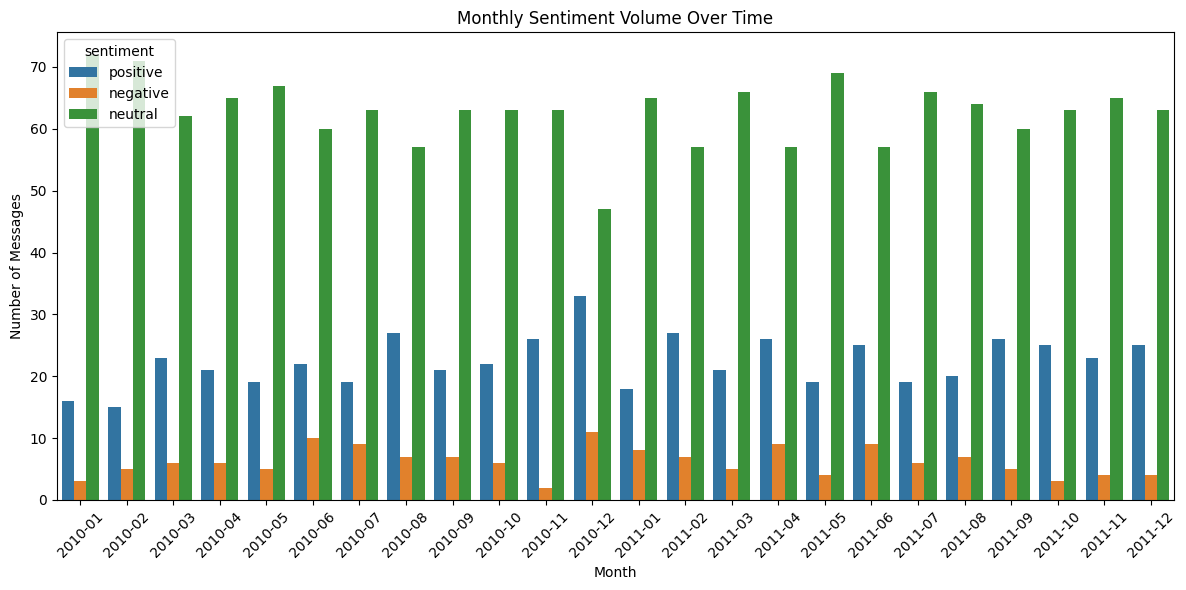

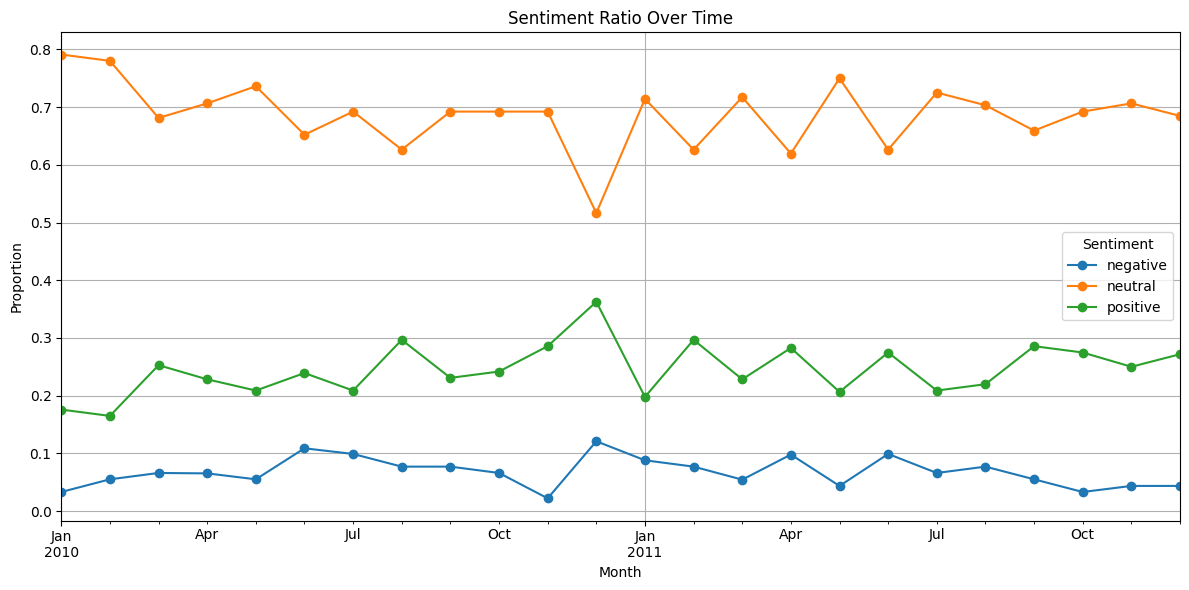

In [39]:
import seaborn as sns

# Step 1: Parse the 'date' column if it's not already in datetime format
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")
df["year_month"] = df["date_parsed"].dt.to_period("M")

# Step 2: Drop rows with invalid dates
df_filtered = df.dropna(subset=["year_month"])

# Step 3: Monthly sentiment count
plt.figure(figsize=(12, 6))
sns.countplot(data=df_filtered, x="year_month", hue="sentiment", order=sorted(df_filtered["year_month"].unique()))
plt.title("Monthly Sentiment Volume Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Messages")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 4: Sentiment ratio per month
sentiment_ratio = df_filtered.groupby("year_month")["sentiment"].value_counts(normalize=True).unstack().fillna(0)

sentiment_ratio.plot(kind="line", figsize=(12, 6), marker="o")
plt.title("Sentiment Ratio Over Time")
plt.ylabel("Proportion")
plt.xlabel("Month")
plt.legend(title="Sentiment")
plt.grid(True)
plt.tight_layout()
plt.show()


In the monthly sentiment over time graph, neutral sentiment emails are the highest with negative emails being consistently the lowest. This could possibly indicate healthy communication. If positive sentiment is healthy and increasing alongside neutral, this could reflect professional yet constructive engagement. However,low negativity alone doesn’t guarantee employee well-being as it may reflect disengagement rather than harmony.

In the sentiment ratio over time graph, it can be observed that for neutral emails, it is most frequent in Jan 2010 and lowest in December 2010. For negative emails, it is lowest in November 2010, and highest in December 2010. For positive emails, it is also highest in December 2010, and lowest in February 2010. December 2010 shows heightened emotional polarization as positive and negative emails peak in this month.
This suggests stronger emotional employee engagement at the end of the year possibly due to year-end stress or celebration, performance reviews, project deadlines, and/or organizational changes (e.g., bonuses, restructuring, layoffs). The large drop in neutral emails from January to December may reflect increasing emotional transparency as the year progresses, anda a shift from routine communication to more reactive and expressive messaging. 

**Trend 2: Length of Email as Indicator for Employee Engagement**

The length of employee email can be a strong indicator for employee engagement as longer emails suggest more effort, though, or emotional investment which are potential signs of active engagement. Shorter emails can indicate disengagement, minimal communication, or burnout from the employees. Sudden drops in length suggest a decline in motivation while sudden spikes can reflect emotional stress especially paired with negative sentiment.  

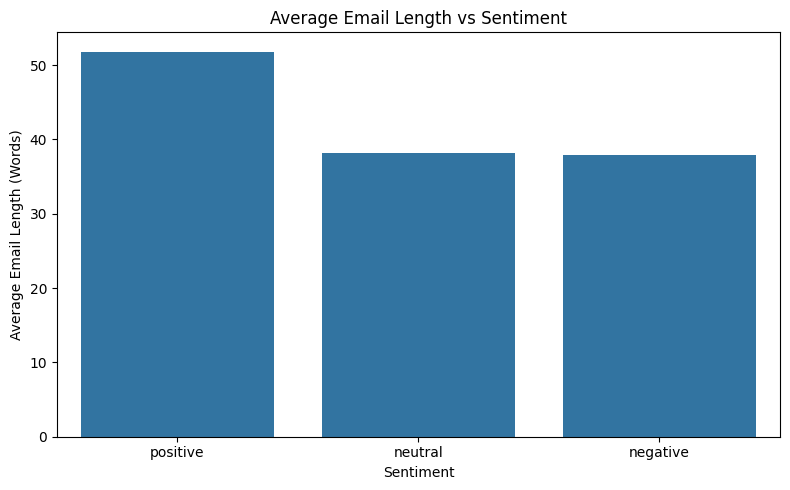

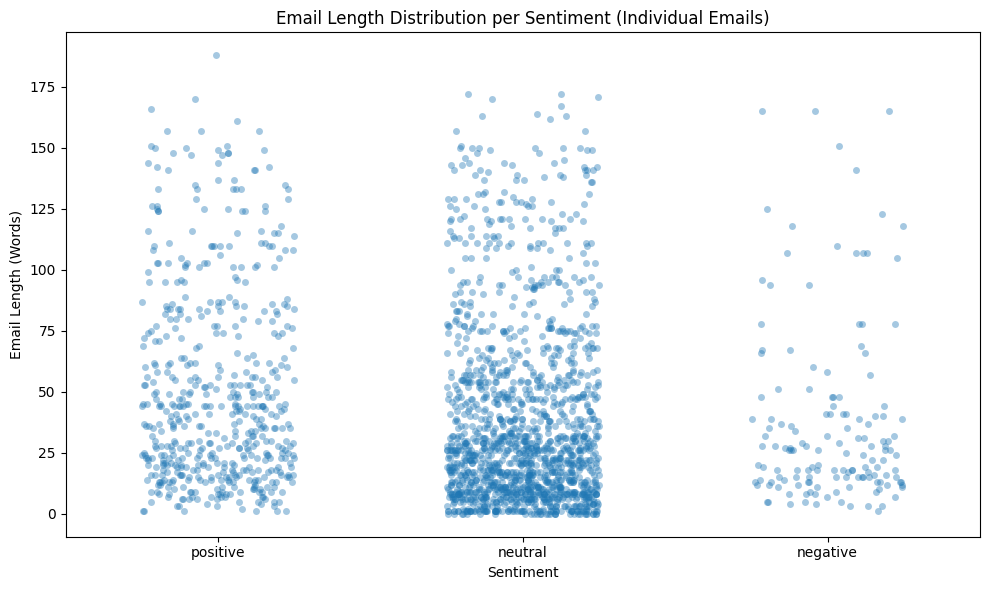

In [40]:
# Step 1: Ensure email length (words) column exists
df["email_length_words"] = df["body"].fillna("").apply(lambda x: len(x.split()))

# Step 2: Compute average email length by sentiment
avg_length_by_sentiment = df.groupby("sentiment")["email_length_words"].mean().reset_index()

# Step 3: Bar plot - Avg email length per sentiment
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_length_by_sentiment, x="sentiment", y="email_length_words", order=["positive", "neutral", "negative"])
plt.title("Average Email Length vs Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Email Length (Words)")
plt.tight_layout()
plt.show()

# Step 4: Optional scatter plot for per-email view
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x="sentiment", y="email_length_words", jitter=0.25, alpha=0.4, order=["positive", "neutral", "negative"])
plt.title("Email Length Distribution per Sentiment (Individual Emails)")
plt.xlabel("Sentiment")
plt.ylabel("Email Length (Words)")
plt.tight_layout()
plt.show()


The graph of Average Email Length vs Sentiment shows positive emails with a higher word count while neutral and negative emails are around the same length. This demonstrates that positive emails tends to be more expressive and thoughtful with employees putting more effort into articulating appreciation, praise, or encouragement. These messages may include context, gratitude, and elaboration, which aligns with higher engagement. Neutral and negative emails are more concise, which indicates blunt or short communication, often associated with frustration or urgency. This can also be associated with employees not feeling safe or motivated to elaborate and could suggest growing dissatisfaction or risk of disengagement.

**Trend 3: Length of sentences per email vs sentiment as Indicator for Employee Engagement**

Positive emails will often have the longest sentences which can be interpreted as thoughtful, expressive, and articulate messages that indicate higher engagement and positive emotional energy. Employees may take time to explain, appreciate, or elaborate their ideas and opinions. Neutral emails may have medium sentence length and can be interpreted as objective and factual tone suggesting positive communication. Negative emails will have the shortest sentences that reflect abrupt communication. 

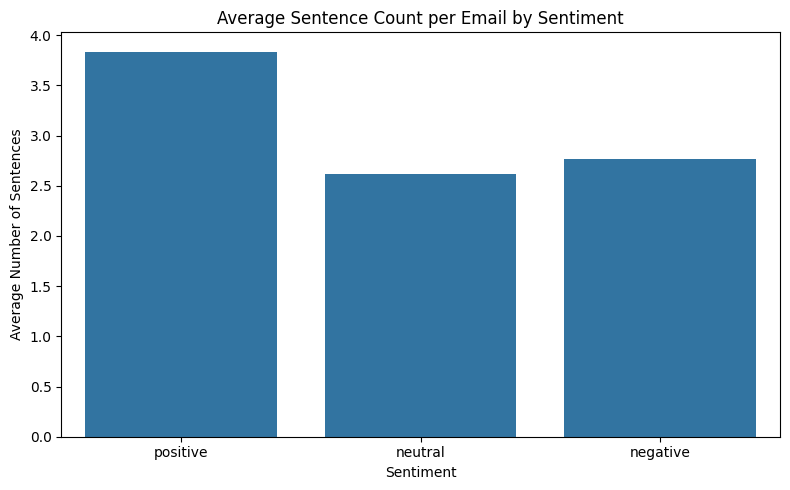

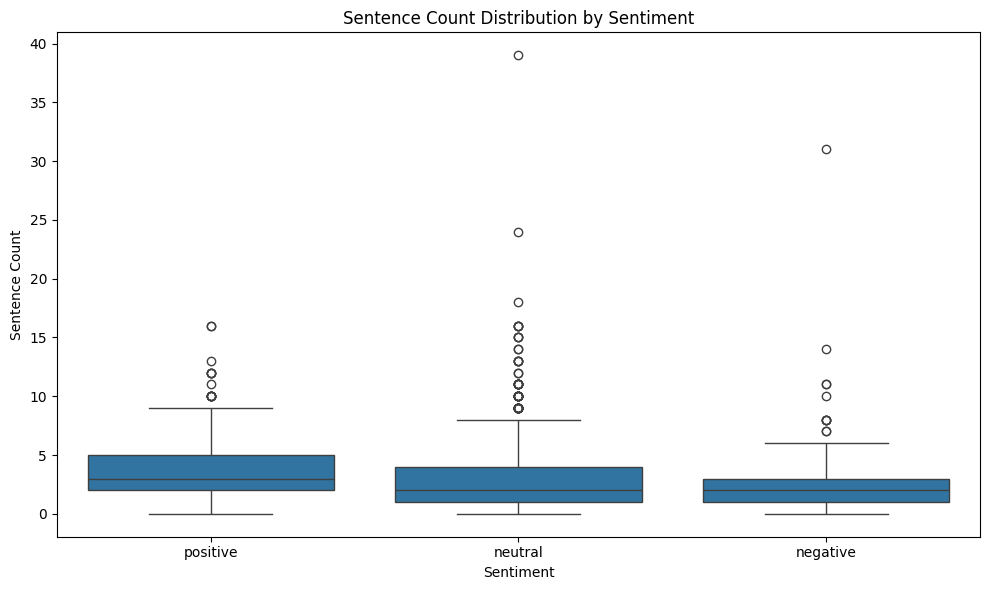

In [41]:
import re

# Step 1: Calculate sentence count per email
def count_sentences(text):
    if not isinstance(text, str):
        return 0
    # Simple sentence splitter: counts '.', '!', or '?' followed by a space or end of text
    return len(re.findall(r'[.!?](?:\s|$)', text))

df["sentence_count"] = df["body"].apply(count_sentences)

# Step 2: Average sentence count by sentiment
avg_sentences_by_sentiment = df.groupby("sentiment")["sentence_count"].mean().reset_index()

# Step 3: Plot average sentence count by sentiment
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_sentences_by_sentiment, x="sentiment", y="sentence_count", order=["positive", "neutral", "negative"])
plt.title("Average Sentence Count per Email by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Number of Sentences")
plt.tight_layout()
plt.show()

# Step 4 (optional): Distribution per sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="sentiment", y="sentence_count", order=["positive", "neutral", "negative"])
plt.title("Sentence Count Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Sentence Count")
plt.tight_layout()
plt.show()

The bar graph shows positive emails have the longest sentences while neutral emails often have the shortest. Negative emails actually have slightly higher sentence length than neutral emails. The sentence count distribution graph shows positive emails having the smallest number of sentences while neutral emails have the most sentences.    

# Task 3: Employee Score Calculation 

Compute a monthly sentiment score for each employee based on their messages.

- **Positive Message**: +1

- **Negative Message**: –1

- **Neutral Message**: 0 (no effect)

- Aggregate these scores on a monthly basis for each employee.

- Ensure that the score resets at the beginning of each new month.

- Clearly document your method for grouping messages by month and calculating the cumulative score

In [49]:
import pandas as pd

# STEP 1: Parse date column to datetime
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")

# STEP 2: Extract year-month for monthly aggregation
df["year_month"] = df["date_parsed"].dt.to_period("M")

# STEP 3: Map sentiment labels to numeric scores
# Positive = +1, Negative = -1, Neutral = 0
sentiment_map = {"positive": 1, "negative": -1, "neutral": 0}
df["sentiment_score"] = df["sentiment"].map(sentiment_map)

# STEP 4: Group by employee (sender) and month, then sum sentiment scores
monthly_sentiment_score = (
    df.groupby(["from", "year_month"])["sentiment_score"]
    .sum()
    .reset_index()
    .rename(columns={"sentiment_score": "monthly_sentiment_score"})
)

print(monthly_sentiment_score)

                            from year_month  monthly_sentiment_score
0    bobette.riner@ipgdirect.com    2010-01                        0
1    bobette.riner@ipgdirect.com    2010-02                        3
2    bobette.riner@ipgdirect.com    2010-03                        0
3    bobette.riner@ipgdirect.com    2010-04                        1
4    bobette.riner@ipgdirect.com    2010-05                        2
5    bobette.riner@ipgdirect.com    2010-06                        0
6    bobette.riner@ipgdirect.com    2010-07                        1
7    bobette.riner@ipgdirect.com    2010-08                       -1
8    bobette.riner@ipgdirect.com    2010-09                        3
9    bobette.riner@ipgdirect.com    2010-10                        3
10   bobette.riner@ipgdirect.com    2010-11                        6
11   bobette.riner@ipgdirect.com    2010-12                        3
12   bobette.riner@ipgdirect.com    2011-01                        0
13   bobette.riner@ipgdirect.com  

# Task 4: Employee Ranking

Generate ranked lists of employees based on their monthly sentiment scores.

Create two distinct lists:

- **Top Three Positive Employees**: The three employees with the highest positive scores in a given month.

- **Top Three Negative Employees**: The three employees with the lowest (most negative) scores in each month.

Sort them first in descending order and then in alphabetical order.

- Ensure that the ranking is clearly derived from the monthly scores calculated in Task 3.

- Present the rankings in a clear and organized format (e.g., tables or charts).

In [63]:
import pandas as pd

# Load your sentiment-annotated dataset
df = pd.read_csv("test_with_sentiment.csv")

# Convert date to datetime and extract year-month
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")
df["year_month"] = df["date_parsed"].dt.to_period("M").astype(str)

# Map sentiment to numeric score
sentiment_map = {"positive": 1, "negative": -1, "neutral": 0}
df["sentiment_score"] = df["sentiment"].map(sentiment_map)

# Aggregate monthly sentiment score per employee, sort alphabetically by 'from', then by month
monthly_sentiment_score = (
    df.groupby(["from", "year_month"])["sentiment_score"]
    .sum()
    .reset_index()
    .rename(columns={"sentiment_score": "monthly_sentiment_score"})
    .sort_values(by=["from", "year_month"])
    .reset_index(drop=True)
)

# Generate rankings
top_positive = []
top_negative = []

for month in sorted(monthly_sentiment_score["year_month"].unique()):
    month_data = monthly_sentiment_score[monthly_sentiment_score["year_month"] == month]

    # Top 3 positive
    top_pos = (
        month_data.sort_values(by=["monthly_sentiment_score", "from"], ascending=[False, True])
        .head(3)
        .copy()
    )
    top_pos["rank_type"] = "Top Positive"
    top_pos["rank"] = range(1, len(top_pos) + 1)
    top_positive.append(top_pos)

    # Top 3 negative
    top_neg = (
        month_data.sort_values(by=["monthly_sentiment_score", "from"], ascending=[True, True])
        .head(3)
        .copy()
    )
    top_neg["rank_type"] = "Top Negative"
    top_neg["rank"] = range(1, len(top_neg) + 1)
    top_negative.append(top_neg)

# Combine into distinct lists
top_positive_employees = pd.concat(top_positive).reset_index(drop=True)
top_negative_employees = pd.concat(top_negative).reset_index(drop=True)

# Optionally save or display
top_positive_employees.to_csv("top_positive_employees.csv", index=False)
top_negative_employees.to_csv("top_negative_employees.csv", index=False)


In [69]:
from IPython.display import display
print("Top 3 Positive Employees:")
display(top_positive_employees)

# Top Three Positive Employees in descending / alphabetical order

Top 3 Positive Employees:


from year_month  monthly_sentiment_score  \
0           eric.bass@enron.com    2010-01                        3   
1        don.baughman@enron.com    2010-01                        2   
2       kayne.coulter@enron.com    2010-01                        2   
3   bobette.riner@ipgdirect.com    2010-02                        3   
4        don.baughman@enron.com    2010-02                        3   
5       johnny.palmer@enron.com    2010-02                        3   
6          sally.beck@enron.com    2010-03                        6   
7           eric.bass@enron.com    2010-03                        3   
8         john.arnold@enron.com    2010-03                        3   
9       kayne.coulter@enron.com    2010-04                        4   
10        john.arnold@enron.com    2010-04                        3   
11       don.baughman@enron.com    2010-04                        2   
12          eric.bass@enron.com    2010-05                        3   
13         sally.beck@enron.com    2010-05                        3   
14  bobette.riner@ipgdirect.com    2010-05                        2   
15         sally.beck@enron.com    2010-06                        5   
16       don.baughman@enron.com    2010-06                        3   
17      johnny.palmer@enron.com    2010-06                        3   
18          eric.bass@enron.com    2010-07                        3   
19         sally.beck@enron.com    2010-07                        3   
20       don.baughman@enron.com    2010-07                        2   
21         sally.beck@enron.com    2010-08                        7   
22        john.arnold@enron.com    2010-08                        3   
23       don.baughman@enron.com    2010-08                        2   
24     patti.thompson@enron.com    2010-09                        4   
25  bobette.riner@ipgdirect.com    2010-09                        3   
26         sally.beck@enron.com    2010-09                        3   
27      lydia.delgado@enron.com    2010-10                        7   
28      johnny.palmer@enron.com    2010-10                        4   
29  bobette.riner@ipgdirect.com    2010-10                        3   
30  bobette.riner@ipgdirect.com    2010-11                        6   
31         sally.beck@enron.com    2010-11                        4   
32        john.arnold@enron.com    2010-11                        3   
33        john.arnold@enron.com    2010-12                        7   
34         sally.beck@enron.com    2010-12                        5   
35      lydia.delgado@enron.com    2010-12                        4   
36      johnny.palmer@enron.com    2011-01                        6   
37          eric.bass@enron.com    2011-01                        3   
38       don.baughman@enron.com    2011-01                        2   
39      johnny.palmer@enron.com    2011-02                        7   
40        john.arnold@enron.com    2011-02                        6   
41      lydia.delgado@enron.com    2011-02                        4   
42      lydia.delgado@enron.com    2011-03                        5   
43      kayne.coulter@enron.com    2011-03                        3   
44     patti.thompson@enron.com    2011-03                        3   
45  bobette.riner@ipgdirect.com    2011-04                        5   
46          eric.bass@enron.com    2011-04                        5   
47      lydia.delgado@enron.com    2011-04                        3   
48      johnny.palmer@enron.com    2011-05                        4   
49      lydia.delgado@enron.com    2011-05                        4   
50         sally.beck@enron.com    2011-05                        3   
51      johnny.palmer@enron.com    2011-06                        7   
52          eric.bass@enron.com    2011-06                        3   
53  bobette.riner@ipgdirect.com    2011-06                        2   
54         sally.beck@enron.com    2011-07                        4   
55      johnny.palmer@enron.com    2011-07         

In [86]:
from IPython.display import display
print("Top 3 Negative Employees:")
display(top_negative_employees)

# Top Three Negative Employees in descending / alphabetical order

Top 3 Negative Employees:


from year_month  monthly_sentiment_score  \
0   bobette.riner@ipgdirect.com    2010-01                        0   
1       rhonda.denton@enron.com    2010-01                        0   
2          sally.beck@enron.com    2010-01                        0   
3       kayne.coulter@enron.com    2010-02                       -1   
4          sally.beck@enron.com    2010-02                       -1   
5         john.arnold@enron.com    2010-02                        0   
6   bobette.riner@ipgdirect.com    2010-03                        0   
7        don.baughman@enron.com    2010-03                        0   
8       kayne.coulter@enron.com    2010-03                        0   
9           eric.bass@enron.com    2010-04                        0   
10     patti.thompson@enron.com    2010-04                        0   
11         sally.beck@enron.com    2010-04                        0   
12       don.baughman@enron.com    2010-05                        0   
13      johnny.palmer@enron.com    2010-05                        0   
14        john.arnold@enron.com    2010-05                        1   
15      kayne.coulter@enron.com    2010-06                       -2   
16      lydia.delgado@enron.com    2010-06                       -1   
17  bobette.riner@ipgdirect.com    2010-06                        0   
18        john.arnold@enron.com    2010-07                       -1   
19      rhonda.denton@enron.com    2010-07                       -1   
20      kayne.coulter@enron.com    2010-07                        0   
21  bobette.riner@ipgdirect.com    2010-08                       -1   
22          eric.bass@enron.com    2010-08                        1   
23     patti.thompson@enron.com    2010-08                        1   
24       don.baughman@enron.com    2010-09                       -1   
25        john.arnold@enron.com    2010-09                       -1   
26      kayne.coulter@enron.com    2010-09                        0   
27     patti.thompson@enron.com    2010-10                       -2   
28         sally.beck@enron.com    2010-10                       -1   
29       don.baughman@enron.com    2010-10                        0   
30      johnny.palmer@enron.com    2010-11                        0   
31       don.baughman@enron.com    2010-11                        1   
32          eric.bass@enron.com    2010-11                        2   
33       don.baughman@enron.com    2010-12                       -1   
34      johnny.palmer@enron.com    2010-12                        0   
35      rhonda.denton@enron.com    2010-12                        0   
36      kayne.coulter@enron.com    2011-01                       -1   
37         sally.beck@enron.com    2011-01                       -1   
38  bobette.riner@ipgdirect.com    2011-01                        0   
39  bobette.riner@ipgdirect.com    2011-02                       -1   
40         sally.beck@enron.com    2011-02                       -1   
41       don.baughman@enron.com    2011-02                        0   
42          eric.bass@enron.com    2011-03                       -1   
43      johnny.palmer@enron.com    2011-03                        0   
44         sally.beck@enron.com    2011-03                        0   
45        john.arnold@enron.com    2011-04                       -1   
46      rhonda.denton@enron.com    2011-04                        0   
47         sally.beck@enron.com    2011-04                        0   
48  bobette.riner@ipgdirect.com    2011-05                        0   
49          eric.bass@enron.com    2011-05                        0   
50        john.arnold@enron.com    2011-05                        0   
51      kayne.coulter@enron.com    2011-06                       -1   
52     patti.thompson@enron.com    2011-06                       -1   
53      rhonda.denton@enron.com    2011-06                        0   
54          eric.bass@enron.com    2011-07                        0   
55      kayne.coulter@enron.com    2011-07         

# Task 5: Flight Risk Identification

Identify employees who are at risk of leaving based on their monthly sentiment scores.

- A Flight risk is any employee who has sent 4 or more negative mails in the span of 30 days (irrespective of the score).

- The 30-day period is rolling count of days, irrepective of months.

- Extract a list of these employees

In [77]:
import pandas as pd

# Load the dataset
df = pd.read_csv("test_with_sentiment.csv")

# Convert date to datetime format
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")

# Filter only negative sentiment emails
negatives = df[df["sentiment"] == "negative"].copy()

# Sort by sender and date
negatives = negatives.sort_values(by=["from", "date_parsed"])

# Collect at-risk employees and their negative email counts
flight_risk_data = []

# Group by employee
for sender, group in negatives.groupby("from"):
    dates = group["date_parsed"].dropna().sort_values().tolist()
    # Sliding window: check any 4 emails within 30 days
    for i in range(len(dates) - 3):
        if (dates[i + 3] - dates[i]).days <= 30:
            flight_risk_data.append({"at_risk_employee": sender, "negative_email_count": len(dates)})
            break

# Output the result as a DataFrame
flight_risk_df = pd.DataFrame(flight_risk_data).sort_values(by="at_risk_employee").reset_index(drop=True)
print(flight_risk_df)

          at_risk_employee  negative_email_count
0   don.baughman@enron.com                    11
1      eric.bass@enron.com                    10
2    john.arnold@enron.com                    18
3  rhonda.denton@enron.com                    13


# Task 6: Predictive Modeling 

Develop a linear regression model to analyze sentiment trends and predict sentiment scores using a variety of independent variables that may influence sentiment scores.

Select independent variables (features) you believe may influence sentiment scores. You are encouraged to use:

Requirements:

- Select appropriate features from the dataset that may influence sentiment scores (e.g., message frequency in a month, message length, average message length, word count).

- Split the data into training and testing sets to evaluate model performance.

- Develop a linear regression model and validate its effectiveness using suitable metrics.

- Interpret the model results and discuss the significance of the findings.

In [130]:
import pandas as pd

# Load dataset
df = pd.read_csv("test_with_sentiment.csv")

# Ensure valid text fields
df["body"] = df["body"].fillna("")
df["Subject"] = df["Subject"].fillna("")

# Parse date and derive month
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year_month"] = df["date"].dt.to_period("M").astype(str)

# Derived per-email features
df["word_count"] = df["body"].apply(lambda x: len(x.split()))
df["message_length"] = df["body"].apply(len)
df["subject_length"] = df["Subject"].apply(len)
df["subject_excl_count"] = df["Subject"].apply(lambda x: x.count("!"))
df["question_mark_count"] = df["body"].apply(lambda x: str(x).count("?"))

# Aggregate per employee per month
features = df.groupby(["from", "year_month"]).agg(
    email_count=("body", "count"),
    avg_word_count=("word_count", "mean"),
    avg_message_length=("message_length", "mean"),
    std_word_count=("word_count", "std"),
    std_message_length=("message_length", "std"),
    subject_excl_count=("subject_excl_count", "mean"),
    avg_subject_length=("subject_length", "mean"),
    avg_question_marks = ("question_mark_count", "mean"),
    num_unique_subjects=("Subject", "nunique")
).fillna(0).reset_index()

# Create a numerical sentiment score
sentiment_map = {"negative": -1, "neutral": 0, "positive": 1}
df["sentiment_score"] = df["sentiment"].map(sentiment_map)
monthly_sentiment_score = df.groupby(["from", "year_month"])["sentiment_score"].sum().reset_index(name="monthly_sentiment_score")

# Merge features with target
full_data = pd.merge(features, monthly_sentiment_score, on=["from", "year_month"])

# preview 10 random samples
print(full_data.sample(n=10, random_state=42))


                            from year_month  email_count  avg_word_count  \
24        don.baughman@enron.com    2010-01            9       31.333333   
6    bobette.riner@ipgdirect.com    2010-07           12       43.833333   
93         john.arnold@enron.com    2011-10           18       55.888889   
109      johnny.palmer@enron.com    2011-02           17       46.647059   
104      johnny.palmer@enron.com    2010-09           12       44.333333   
172     patti.thompson@enron.com    2010-05           16       37.187500   
233         sally.beck@enron.com    2011-06            2       12.000000   
86         john.arnold@enron.com    2011-03           10       43.900000   
9    bobette.riner@ipgdirect.com    2010-10            6       47.666667   
143      kayne.coulter@enron.com    2011-12            9       54.555556   

     avg_message_length  std_word_count  std_message_length  \
24           216.333333       33.196385          235.289184   
6            278.583333       46.5497

R² Score: 0.149
Mean Squared Error: 3.411


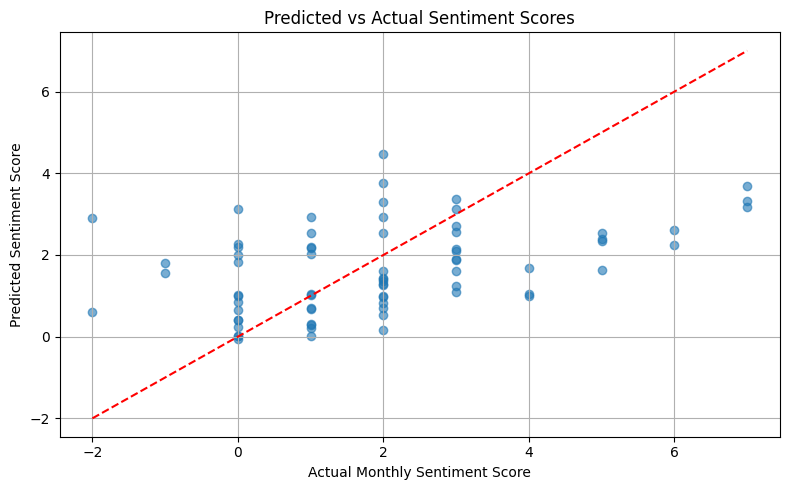

Model Intercept: -0.2453747082027118

Model Coefficients:
avg_word_count         0.003002
subject_excl_count     0.364288
avg_question_marks    -0.041239
num_unique_subjects    0.191198
dtype: float64


In [137]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# 1. Select best-performing features (X)
features = [
    "avg_word_count",
    "subject_excl_count",
    "avg_question_marks",
    "num_unique_subjects"
]
X = full_data[features]

# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, full_data["monthly_sentiment_score"], test_size=0.3, random_state=42
)

# 3. Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict
y_pred = model.predict(X_test)

# 5. Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R² Score: {r2:.3f}")
print(f"Mean Squared Error: {mse:.3f}")

# 6. Plot predictions
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Monthly Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Predicted vs Actual Sentiment Scores")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Coefficients (feature importance)
print("Model Intercept:", model.intercept_)
coefficients = pd.Series(model.coef_, index=features)
print("\nModel Coefficients:")
print(coefficients)

Features from the dataset that influence sentiment include avg word count, message length, subject length, subject excl count, question mark count. Other features that are grouped by sender and year_month to align with monthly sentiment include email_count, avg_word_count, avg_message_length, std_word_count, std_message_length, subject_excl_count, avg_subject_length=, avg_question_marks, num_unique_subjects, avg word count, message length,  subject length, avg question marks.  

Behavioral Features (Aggregated Over Time)
- email_count: A sharp drop in email count might reflect disengagement which is a possible negative signal. High volume may indicate high workload or engagement.
- num_unique_subjects: Variety in subjects might suggest an employee is involved in diverse work (potentially correlating with engagement and positive sentiment. Low variety might mean repetitive tasks, which could relate to burnout or negative tone.
- avg_hour_of_day: Sending emails outside normal hours may indicate overwork or stress — possibly correlating with negative sentiment. Mid-day communications may be more neutral or positive.

- **Model Development**: The linear regression model uses LinearRegression from scikit-learn which trains the model on the training set and validates it using metrics like mean squared error (MSE) and  R² score.
- **R²: 0.149** - This shows that the model explains ~15% of the variance in monthly sentiment scores, which shows that it is a meaningful  predictor of monthly sentiment score especially in noisy data like emails.
- **MSE: 3.411** - The average squared error beteween predicted and true sentiment scores is around 3.411. 
- **Intercept: -0.2453747082027118** - The coefficient is negative which indicates that the model predicts a slightly negative baseline.  

- **avg_word_count: +0.0030** - Very small positive effect, longer average email bodies are weakly associated with more positive sentiment.
- **subject_excl_count: +0.3643** - Strongest positive coefficient: more exclamation marks in subject lines are linked to higher sentiment scores which likely captures positive enthusiasm more than frustration.
- **avg_question_marks: –0.0412** - Slightly negative: more question marks in emails correlate with more negative sentiment, possibly reflecting confusion, doubt, or dissatisfaction.
- **num_unique_subjects: +0.1912** - Moderate positive: diverse subject lines suggest engagement with multiple tasks or areas — tied to more positive sentiment.
